# Knowledge Graph

In [1]:
import pandas as pd
import spacy
from spacy.matcher import Matcher 
from spacy import displacy
from spacytextblob.spacytextblob import SpacyTextBlob  # for sentiment
import networkx as nx
import matplotlib.pyplot as plt

## Read raw example data

In [2]:
# I made this in R using expand.grid() since I don't know the Python equivalent
book = pd.read_csv("data/book.csv")
book.head()

,study,region,subregion,country
0,1,1,1,1
1,1,1,1,2
2,1,1,1,3
3,1,1,1,4
4,1,1,1,5


In [3]:
# the raw data of reviews
rev = pd.read_csv("data/amazon_alexa.tsv", delimiter='\t')
rev.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
# only really want one column
book['text'] = rev['verified_reviews'][0:599]

I think the raw data will look something like this.

In [5]:
book.head()

,study,region,subregion,country,text
0,1,1,1,1,Love my Echo!
1,1,1,1,2,Loved it!
2,1,1,1,3,"Sometimes while playing a game, you can answer..."
3,1,1,1,4,I have had a lot of fun with this thing. My 4 ...
4,1,1,1,5,Music


## Prepare data

Some text entries have more than one sentence, so I need to split those into individual sentences.

In [6]:
book['text'][2]

'Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home.'

In [7]:
nlp = spacy.load("en_core_web_md")

Need to check each row in the text column to see if it has more than one sentence. If so, split it and add one to the dataframe for each sentence. Also need to delete the row with the multi-sentence text field. There's probably a better way of doing this.

In [8]:
book_sent = pd.DataFrame(columns=('study', 'region', 'subregion', 'country', 'text'))
count = 0

for i in range(len(book)):
    if isinstance(book['text'][i], str): # there are non-string entries, so ignore those
        doc = nlp(book['text'][i])
        for sent in doc.sents:
            if sent.text == " ": continue   # splitting multiple sentences sometimes produces a sentence with just a space 
            row_to_append = book.loc[i][0:4].tolist()
            row_to_append.append(sent.text)
            book_sent.loc[count] = row_to_append
            count += 1

In [9]:
# check dataframe to see if it looks right. The old row 2 is now split into two rows (rows 2 and 3).
book_sent.head()

,study,region,subregion,country,text
0,1,1,1,1,Love my Echo!
1,1,1,1,2,Loved it!
2,1,1,1,3,"Sometimes while playing a game, you can answer..."
3,1,1,1,3,I like being able to turn lights on and off wh...
4,1,1,1,4,I have had a lot of fun with this thing.


## Get subject and object pairs

From here on, the code was lifted from https://www.kaggle.com/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk with some minor edits due to syntax changes between spaCy versions.

In [10]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [11]:
entity_pairs = [get_entities(i) for i in book_sent['text']] # I modified this to use list comprehension

In [12]:
entity_pairs[0:10]

[['', 'Echo'],
 ['', 'it'],
 ['you', 'you'],
 ['I', 'away  home'],
 ['I', 'thing'],
 ['i', 'categories'],
 ['', 'when  music'],
 ['', ''],
 ['I', 'gift'],
 ['I', 'smart  speaker']]

## Get the relationship between subject and object

In [13]:
# imports from the Kaggle post I didn't use but kept just in case

#import re
#import bs4
#import requests
#from spacy import displacy
#from spacy.tokens import Span 
#import matplotlib.pyplot as plt
#%matplotlib inline

In [14]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  # I modified the pattern list below from the Kaggle post. Old syntax:
  #pattern = [{'DEP':'ROOT'}, 
  #          {'DEP':'prep','OP':"?"},
  #          {'DEP':'agent','OP':"?"},  
  #          {'POS':'ADJ','OP':"?"}]
  pattern = [
      [{'DEP':'ROOT'}],
      [{'DEP':'prep','OP':"?"}],
      [{'DEP':'agent','OP':"?"}],  
      [{'POS':'ADJ','OP':"?"}]
  ]

  matcher.add("matching_1", pattern) # in the kaggle post, matcher.add() had three arguments

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [15]:
relations = [get_relation(i) for i in book_sent['text']]

# look at the 20 most common relations. Not that both love and Love are listed separately.
pd.Series(relations).value_counts()[:20]

for      88
great    56
to       56
with     55
new      51
of       49
in       45
love     45
Love     43
on       28
more     26
good     21
from     18
easy     18
like     18
as       16
smart    15
works    13
about    13
other    12
dtype: int64

## Build knowledge graph

In [16]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [17]:
# create a directed-graph from the dataframe. This includes every relationship for the entire corpus.
G=nx.from_pandas_edgelist(df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

C:\Users\jking\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 55357 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jking\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 56833 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jking\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 55357 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jking\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 56833 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jking\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 56834 missing from current font.
  font.set_text(s, 0.0, flags=flags)


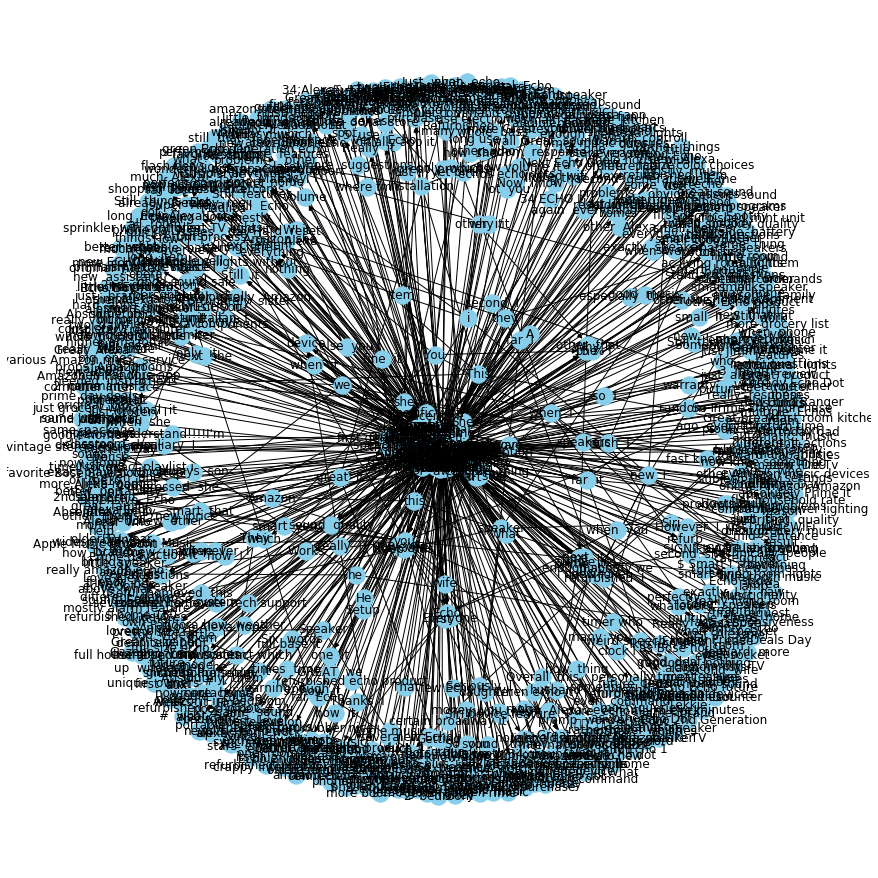

In [18]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

### Refine graph to include only one specified relationship

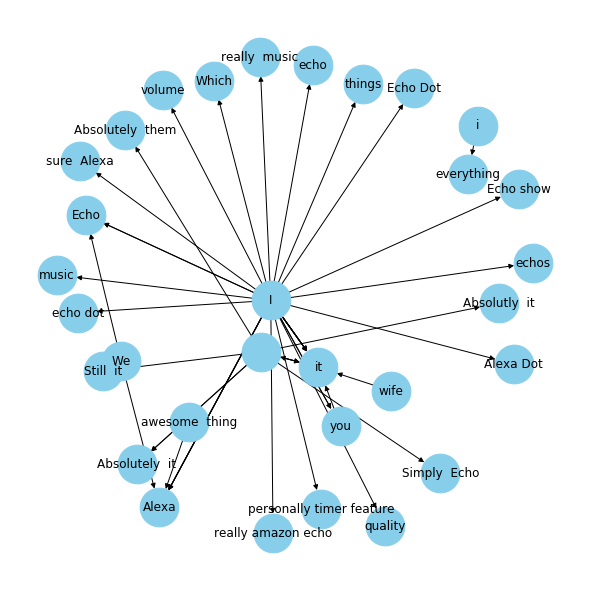

In [19]:
G=nx.from_pandas_edgelist(df[df['edge']=="love"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

There is a blank node and some nodes seem like they should have the word "love" between them, like "Absolutely it". Probably because the review was just "Absolutely love it", so there's no subject. My guess is that this would perform better with more formal writing.

## Named Entity Recognition

In [40]:
book['text'][10]      # demonstrate on the text in the 10th row

'I sent it to my 85 year old Dad, and he talks to it constantly.'

Text: The original entity text.

Start: Index of start of entity in the Doc.

End: Index of end of entity in the Doc. GPE is geopolitical entity.

Label: Entity label, i.e. type.

In [39]:
doc = nlp(book['text'][10])

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

85 year old 16 27 DATE
Dad 28 31 PERSON


In [41]:
displacy.render(doc, style='ent', jupyter=True)

## Similarity

We can measure the similarity of the text associated with two countries (or regions, etc.) as follows.

In [25]:
country1 = nlp(' '.join(book[book['country'] == 1]['text']))
country2 = nlp(' '.join(book[book['country'] == 2]['text']))

country1.similarity(country2)

0.9991340493454961

## Sentiment

**Polarity** is a float within the range [-1.0, 1.0]. A negative number represents a negative (bad) sentiment. 

In [27]:
nlp.add_pipe("spacytextblob")

# merge all of the text into one long document for each country
country1 = nlp(' '.join(book[book['country'] == 1]['text'])) 
country2 = nlp(' '.join(book[book['country'] == 2]['text']))

print(country1._.polarity, country2._.polarity)

0.36581241874472703 0.30783327667028465


**Subjectivity** is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [28]:
print(country1._.subjectivity, country2._.subjectivity)

0.569743590630172 0.5445348739372059
